In [1]:
!pip freeze > ..//requirements.txt

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
from statsmodels.tsa.stattools import (adfuller, 
                                       acf, pacf)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import (mean_absolute_error, 
                             mean_squared_error, 
                             mean_absolute_percentage_error,
                             r2_score)
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet

# hyperparameters tuning
from hyperopt import STATUS_OK, STATUS_FAIL, Trials, fmin, hp, tpe, space_eval

from hyperopt import space_eval

# Prevenindo logs do cmdstanpy
import warnings
import logging
warnings.filterwarnings('ignore')
logging.getLogger('fbprophet').setLevel(logging.ERROR) 
logging.getLogger('prophet').setLevel(logging.ERROR) 
logging.getLogger('hyperopt.tpe').setLevel(logging.ERROR) 
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [3]:
# deixar data como indice
df = pd\
    .read_csv('../data/raw/dados_ibovespa.csv')\
    .rename(columns={
          'Data':'Date'
        , 'Último':'Close'
        , 'Abertura':'Open'
        , 'Máxima':'High'
        , 'Mínima':'Low'
        , 'Vol.':'Volume'
    })
df['Adj Close'] =  df['Close']
df.Date = pd.to_datetime(df['Date']).dt.date
df = df.sort_values(['Date'])
df['Datetime'] = pd.to_datetime(df['Date'])
df.Open = df.Open.astype(float)
df.Close = df.Close.astype(float)
df.High = df.High.astype(float)
df.Low = df.Low.astype(float)
df.Volume = df.Volume.str.replace('M','000000').str.replace(',','').str.replace('K','000')
df.Volume = df.Volume.astype(float)
df['Base Volume'] = df.Volume.astype(float)
df = df.sort_values(['Datetime'])

# Grafico historico

In [4]:
len(df)

5589

In [5]:
min(df.Date), max(df.Date)

(datetime.date(2000, 12, 27), datetime.date(2023, 7, 21))

In [6]:
from indicators import Indicators, generate_graph
indicators = Indicators(settings='')

df, crossovers, ma_crossovers, bb_crossovers, hammers, suportes, resistencias, high_trend, low_trend, close_trend =  indicators.gen_all(df, 9999, macd_rsi_BB=False, rsi_window=14)

generate_graph(df, crossovers, just_candles=False)

One way to test whether a time series is stationary is to perform an augmented Dickey-Fuller test, which uses the following null and alternative hypotheses:

H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.

HA: The time series is stationary.

In [ ]:
# serie e estacionaria? ADF - augmented dick-fuller
adfuller(df['Close'])

(-0.8924999370250177,
 0.7904322608539279,
 11,
 5577,
 {'1%': -3.4315230881147225,
  '5%': -2.862058389900819,
  '10%': -2.5670459375427312},
 16097.395332513242)

Test statistic was -1.624398
P-value was 0.47

so, we fail to reject the null hypothesis - or, we dont have constant variance over time, since this time series is non-stationary

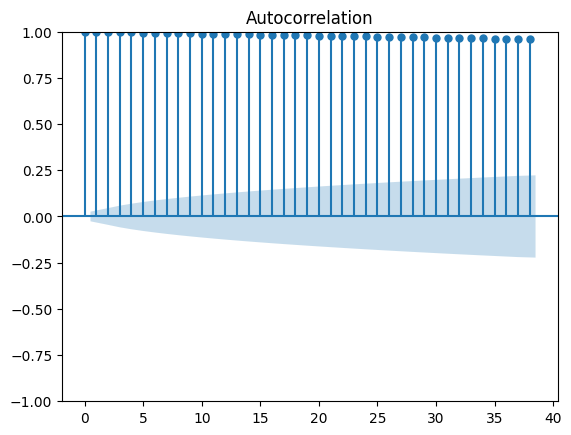

In [ ]:
# ACF / PACF - autocorrelação e autocorrelação parcial 
# https://analyticsindiamag.com/what-are-autocorrelation-and-partial-autocorrelation-in-time-series-data/
acf_plot = plot_acf(df['Close'])

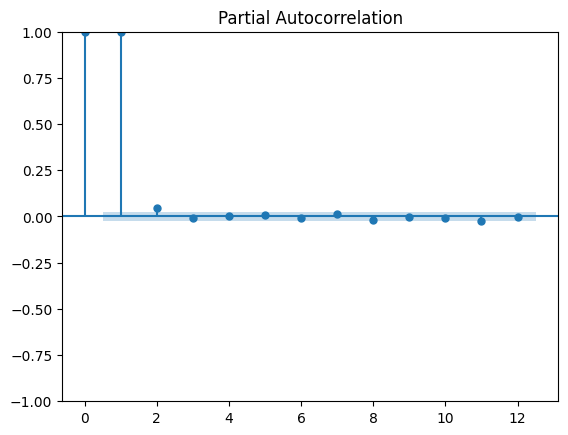

In [ ]:
pacf_plot = plot_pacf(df['Close'], lags=12)

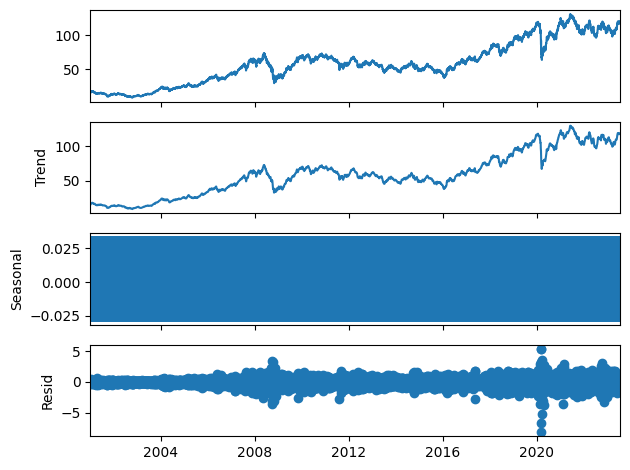

In [ ]:
# componentes da serie
from statsmodels.tsa.seasonal import seasonal_decompose
series = df[['Close']]
series.index = pd.to_datetime(df.Date)
result = seasonal_decompose(series, model='additive', period=5)
result_plot = result.plot()


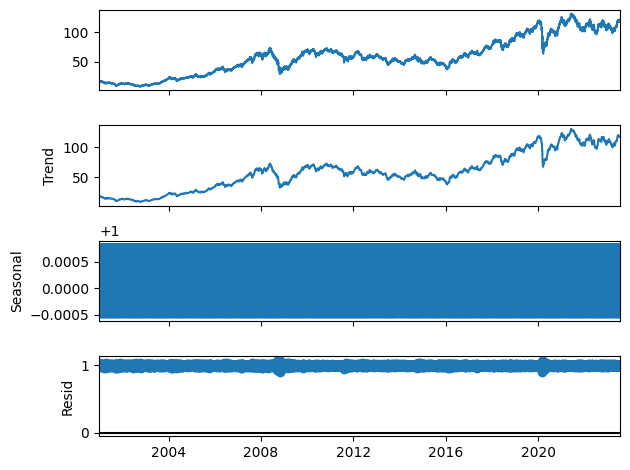

In [ ]:
# componentes da serie - mult
from statsmodels.tsa.seasonal import seasonal_decompose
series = df[['Close']]
series.index = pd.to_datetime(df.Date)
result = seasonal_decompose(series, model='multiplicative', period=5)
result_plot = result.plot()


In [ ]:
# normalização, como diferenciação, logaritmica ou com raízes

In [ ]:
# previsao com arima

In [ ]:
df.Date

Datetime
2000-12-27    2000-12-27
2000-12-28    2000-12-28
2001-01-02    2001-01-02
2001-01-03    2001-01-03
2001-01-04    2001-01-04
                 ...    
2023-07-17    2023-07-17
2023-07-18    2023-07-18
2023-07-19    2023-07-19
2023-07-20    2023-07-20
2023-07-21    2023-07-21
Name: Date, Length: 5589, dtype: object

In [ ]:
# Prophet puro
_model = Prophet()
_res = []

_df = df.reset_index(drop=True)[['Date','Close']].rename(columns={'Date':'ds', 'Close':'y'})

train_end = pd.to_datetime('2023-01-01').date()
X_train = _df.loc[_df.ds < train_end]
X_test = _df.loc[_df.ds >= train_end]

_model.fit(X_train)
forecast_ = _model.predict(X_train)
pred = _model.predict(X_test)
_df = pd.concat([_df, _model.predict(_df)])

_res.append({
    'n_splits':0,
    'test_size':len(X_test),
    'regressors':'',
    'train_index':0,
    'test_index':min(X_test.index),
    'max_date_train':max(X_train.ds),
    'max_date_test':max(X_test.ds),
    'test_mape':mean_absolute_percentage_error(X_test['y'].values, pred['yhat'].values),
    'all_series_mape':mean_absolute_percentage_error(X_train['y'].values, forecast_["yhat"].values)
})
_res

[{'n_splits': 0,
  'test_size': 139,
  'regressors': '',
  'train_index': 0,
  'test_index': 5450,
  'max_date_train': datetime.date(2022, 12, 29),
  'max_date_test': datetime.date(2023, 7, 21),
  'test_mape': 0.10955756557476391,
  'all_series_mape': 0.07545745547605724}]

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(_model, forecast_)

In [ ]:
plot_components_plotly(_model, forecast_)

In [ ]:
# previsao com prophet + BCB como external variables

# hiperparametrização 

- time series split (sklearn) + bayesian search (hyperopt)

Select the search algorithm
The two main choices are:

* hyperopt.tpe.suggest: [Tree of Parzen Estimators](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f#:~:text=The%20Tree%20Parzen%20Estimator%20is,will%20explore%20in%20further%20articles.), a Bayesian approach that iteratively and adaptively selects new hyperparameter settings to explore based on previous results

* hyperopt.rand.suggest: Random search, a non-adaptive approach that samples over the search spac

In [ ]:
# deixar data como indice
df = pd\
    .read_csv('../data/raw/dados_ibovespa.csv')\
    .rename(columns={
          'Data':'Date'
        , 'Último':'Close'
        , 'Abertura':'Open'
        , 'Máxima':'High'
        , 'Mínima':'Low'
        , 'Vol.':'Volume'
    })
df['Adj Close'] =  df['Close']
df.Date = pd.to_datetime(df['Date']).dt.date
df = df.sort_values(['Date'])
df['Datetime'] = pd.to_datetime(df['Date'])
df.Open = df.Open.astype(float)
df.Close = df.Close.astype(float)
df.High = df.High.astype(float)
df.Low = df.Low.astype(float)
df.Volume = df.Volume.str.replace('M','000000').str.replace(',','').str.replace('K','000')
df.Volume = df.Volume.astype(float)
df['Base Volume'] = df.Volume.astype(float)
df = df.sort_values(['Datetime'])

_df = df.reset_index(drop=True)[['Date','Close']].rename(columns={'Date':'ds', 'Close':'y'})

_df['ds'] = pd.to_datetime(_df['ds'])
_df = _df.reset_index()[['ds','y']]

In [ ]:
print(f"""Como vamos executar um cross validation utilizando o time series split, 
      e temos {df.dropna().size} linhas, optando por uma base de teste de 30 dias 
      (aproximadamente 1 mês), podemos executar até {df.dropna().size/30} splits, 
      porém, devido a limitação de tempo, vamos optar por {round((df.dropna().size/31)/10,0)} splits!"""
)

Como vamos executar um cross validation utilizando o time series split, 
      e temos 55880 linhas, optando por uma base de teste de 30 dias 
      (aproximadamente 1 mês), podemos executar até 1862.6666666666667 splits, 
      porém, devido a limitação de tempo, vamos optar por 180.0 splits!


In [ ]:
# previsao com prophet


# cross validation 
def _run_cv_prophet(df_model, best_params, n_splits = 5, test_size = 12,):
    tscv =  TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
    for train_index, test_index in tscv.split(df_model):
        X_train, X_test = df_model.iloc[train_index], df_model.iloc[test_index]
        y_train, y_test = df_model.y[train_index], df_model.y[test_index]
        hyper_model = Prophet(
                yearly_seasonality=best_params["yearly_seasonality"],
                daily_seasonality=best_params["daily_seasonality"],
                weekly_seasonality=best_params["weekly_seasonality"],
                seasonality_mode=best_params['seasonality_mode']
                changepoint_prior_scale=best_params["changepoint_prior_scale"],
                changepoint_range=best_params["changepoint_range"],
                holidays_prior_scale=best_params['holidays_prior_scale']
                )
        # adicionando feriados na execução do modelo
        hyper_model.add_country_holidays(country_name='BR')
        str_regressors = ''
        # for reg in best_params['regressors']:
        #     str_regressors += f'{reg["regressor_name"]}_'
        #     hyper_model.add_regressor(reg["regressor_name"], prior_scale=reg["prior_scale"], mode=reg["mode"])
        hyper_model.fit(X_train)
        forecast_ = hyper_model.predict(X_train)
        pred = hyper_model.predict(X_test)
        
        _res.append({
            'n_splits':n_splits,
            'test_size':test_size,
            'regressors':str_regressors,
            'train_index':train_index,
            'test_index':test_index,
            'max_date_train':max(X_train.ds),
            'max_date_test':max(X_test.ds),
            'test_mape':mean_absolute_percentage_error(y_test, pred['yhat'].values),
            'all_series_mape':mean_absolute_percentage_error(y_train, forecast_["yhat"].values)
        })
    return _res, pd.DataFrame(_res).test_mape.mean()

# definição da função objetivo a ser otimizada usando bayesian search (algoritmo tpe)
def objective(params):
   
    metrics, cv_mape = _run_cv_prophet(
                    df_model=_df.dropna(),
                    best_params=params,
                    n_splits=(180), test_size=30
                   )
    return cv_mape

space = {
    'yearly_seasonality':hp.choice('yearly_seasonality',[True])
    , 'daily_seasonality':hp.choice('daily_seasonality',[True])
    , 'weekly_seasonality':hp.choice('weekly_seasonality',[True])
    , 'seasonality_mode' : hp.choice('seasonality_mode', ['multiplicative','additive'])
    , "changepoint_prior_scale": hp.uniform("changepoint_prior_scale", 0, 2.5)
    , "changepoint_range": hp.uniform("changepoint_range", 0, 1)
    , 'holidays_prior_scale' : hp.uniform('holidays_prior_scale', 0,10)
    , "regressors":''
    # "regressors": hp.choice("regressors", [[{"regressor_name": reg,
    #                                          "prior_scale": hp.uniform(reg + "_prior_scale", 0, 20),
    #                                          "mode": hp.choice(reg + "_mode", ["additive"])
    #                                          } for reg in regressors]])
}

In [ ]:
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, verbose=1)

  0%|          | 0/100 [00:21<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [ ]:
best_params = space_eval(space, best)
print(best_params)

hyper_model = Prophet(
    yearly_seasonality=best_params["yearly_seasonality"],
    daily_seasonality=best_params["daily_seasonality"],
    weekly_seasonality=best_params["weekly_seasonality"],
    changepoint_prior_scale=best_params["changepoint_prior_scale"],
    changepoint_range=best_params["changepoint_range"])

for reg in best_params["regressors"]:
    hyper_model.add_regressor(reg["regressor_name"], prior_scale=reg["prior_scale"], mode=reg["mode"])

hyper_model.fit(X_train)
pred = hyper_model.predict(X_test)
forecast_ = hyper_model.predict(_df)

print('-'*80)

test_y = X_test.loc[(X_test['ds'] >= train_end)]["y"].values
pred_yhat = pred.loc[(pd.to_datetime(pred['ds']) >= pd.to_datetime(train_end))]["yhat"].values
test_period_mape = mean_absolute_percentage_error(X_test['y'].values, pred['yhat'].values)
print('Test period MAPE:' + f'{round(test_period_mape * 100, 3)}'+'%')

all_series_mape = mean_absolute_percentage_error(_df['y'].values, forecast_['yhat'].values)
print('All series MAPE:' + f'{round(all_series_mape * 100, 3)}'+'%')

01:39:06 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 13.965775188152488, 'changepoint_range': 0.45201495192786795, 'daily_seasonality': True, 'regressors': '', 'weekly_seasonality': False, 'yearly_seasonality': False}


01:39:07 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------
Test period MAPE:4.852%
All series MAPE:11.646%


In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(hyper_model, forecast_)

In [ ]:
plot_components_plotly(hyper_model, forecast_)